The project aim to re-improve part of the Sequencer: Deep LSTM for Image Classification, in which was developed a vision transformer with bidirectional LSTM instead of self attention in order to do Image classification. 
Here  I've tried to reproduce 3 of the model present in the paper:
1) the vision transformer with BiLstm in 2 versions, one called "small" which have 2 SequencerBlock(the core part using BiLSTM2D- a bilsttm that split image in horizzontal and vertiacl data before process it ),
2) one called  "medium" which have 3 sequencerBlock.
3) the last one is the same model but with plain BiLstm instead of BiLSTM2D

All the model were trained over 4 classes Cifar10 Dataset ( used in the paper to fine-tuning). Due to resource constraints (limited to 8 GB of RAM on my PCs -I've used one mcbook pro and one Hp both with the same RAM), each model took several days to train. Attempts to train them on a larger number of classes or datasets resulted in significant slowdowns and kernel crashes.

The performance achived by the models were pretty good: nearly 84% of accuracy for the Sequencers2D models and 67.53% for the vanilla Model

In order to run the project it must be installed:
pytorch, torchvision, pandas, pikle, matplotlib and sklearn
and download Cifar10 dataset

Before each block of this code there is a text explaining what the following code is up to do.

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
from torch.utils.data import Dataset

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

BiLSTMVertical :
This is a module that implements a Bidirectional Long Short-Term Memory (BiLSTM) layer with a vertical direction of computation.
It takes two arguments: input_size and hidden_size, which determine the input and hidden state dimensions of the LSTM.
Inside the __init__ method, it initializes an nn.LSTM module with the specified input and hidden sizes. It's set to be bidirectional (bidirectional=True) and accepts input data in batches (batch_first=True).
In the forward method, it applies the BiLSTM to the input tensor x and returns the output.

BiLSTMHorizontal:
This is another module similar to BiLSTMVertical, but it implements a BiLSTM layer with a horizontal direction of computation.
It has the same constructor and forward method structure as BiLSTMVertical.


FullyConnectedLayer:
This module represents a fully connected (linear) layer in a neural network.
It takes two arguments: input_size and output_size, determining the input and output dimensions of the linear layer.
In the __init__ method, it initializes an nn.Linear module with the specified input and output sizes.
In the forward method, it applies the linear transformation to the input tensor x and returns the output.

In [2]:

class BiLSTMVertical(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMVertical, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
        
        
    def forward(self, x):
        output, _ = self.lstm(x)
        return output
    

class BiLSTMHorizontal(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiLSTMHorizontal, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)
       
        
    def forward(self, x):
       
        output, _ = self.lstm(x)
        return output
    
    
class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedLayer, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
       
        # Apply He initialization to linear layer weights
        init.kaiming_normal_(self.fc.weight, mode='fan_out', nonlinearity='relu')


        
    def forward(self, x):
        output = self.fc(x)
        return output



VanillaSequencerBlock

Is a module that implement a block that processes sequential data, normalizes it, applies a bidirectional LSTM, and performs additional normalization and linear transformations.
It will be used as core part of the Vanilla sequencer model, here in fact the image is not divided by horizontal and vertical data.
-The image passed is normalized, by the nn.LayerNorm,

-Then it is processed by the bidirectional Lstm 

- It is summed up wiht the original image data

-After that merging it is again normalized

-It is applied a linear layer.



In [3]:
import torch
import torch.nn as nn

class VanillaSequencerBlock(nn.Module):
    def __init__(self, input_size, hidden_size, mlp_input_size, mlp_output_size):
        super(VanillaSequencerBlock, self).__init__()

        
        self.normal_layer = nn.LayerNorm(input_size)

        
        self.bilstm = nn.LSTM(input_size, hidden_size, bidirectional=True, batch_first=True)

       
        self.normalization_after_merge = nn.LayerNorm(input_size)

        
        self.channel_mlp = nn.Linear(mlp_input_size, mlp_output_size)

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        batch_size,channel, height= x.size()
       
        outputs=[]
        for index in range(batch_size):
            
            
            y=x[index]
           
            y = self.normal_layer(y)
            
            
            
            y,_= self.bilstm(y)
            
            
            
           
            y=y.permute(1,0).clone()
            
            y = self.normalization_after_merge(y)

           
            
            y= self.channel_mlp(y)
            
            
            
            outputs.append(y)
       
        return outputs


Sequencer2D
Is a sequencer in which the input data (images) are splitted into vertical adn horiziontal component.
 Then vertical data will be passed as input to BilstmVertical ,while horizontal_data will be passed to BiLSTMHorizontal,
to do so the input data are first processed in such a way we'll have a tensor with vertical data of each image and another tensor with horizontal data of each image.
 Once we get the outputs from both BiLSTMvertical and BiLSTMHorizontal, we 'll concatenate them and pass as input the result to Fully Connected Layer . At the end of the sequencer the results will be a list of tensor ( each tensor has inside data belongs to each image processed above)

In [4]:


class Sequencer2D(nn.Module):
    def __init__(self, input_size, hidden_size, mlp_input_size, mlp_output_size):
        super(Sequencer2D, self).__init__()

       
        vertical_bilstm = BiLSTMVertical(input_size, hidden_size)
        horizontal_bilstm = BiLSTMHorizontal(input_size, hidden_size)
        fully_connected = FullyConnectedLayer( mlp_input_size,mlp_output_size)  

        # Move models to GPU if available
        #vertical_bilstm.to(device)
        #horizontal_bilstm.to(device)
        #fully_connected.to(device)

        self.vertical_bilstm = vertical_bilstm
        self.horizontal_bilstm = horizontal_bilstm
        self.fully_connected = fully_connected
        
       
        

    def forward(self, x):
        if isinstance(x, list):
            x = torch.stack(x)
        if len(x.shape)==4:
            batch_size,channel, height, width = x.size()
            x=x.squeeze(1)
        elif len(x.shape) == 3 :
            batch_size, height, width = x.size()
        output=[]
        for index in range(batch_size):
            
            x_vertical = x[index][:, :height//2]  #split the image vertically
            x_horizontal = x[index][ :,width//2:]   #split image horizontally

            vertical_data = x_vertical.permute( 1,0).clone() #permutation to fit bilstm
            horizontal_data = x_horizontal.permute( 1,0).clone()#same here
            
            
            
            H_ver = self.vertical_bilstm(vertical_data)
            H_hor = self.horizontal_bilstm(horizontal_data)
            
            
            H_ver = H_ver.permute(1,0).clone() #permute to fit torch.cat
            H_hor = H_hor.permute(1,0).clone()
            
           
            
            
            H_concat = torch.cat((H_ver, H_hor), dim=1)#concatenaiton of the horizontal and vertical bilstm outputs
            H_concat = H_concat.unsqueeze(0) #set dimension to fit fully conncted layer

            
            
            
            
            
            
            output_pieces = self.fully_connected(H_concat)
            
            
            output.append(output_pieces) #add output to lists of each image data processed here
        
        return output


Patch Embedding : this costum function given an image , a patch size, will splitted the image in image_size/patch_size pieces.

image_size: The size of the input image. It represents both the height and width of the image.
patch_size: The size of each non-overlapping patch that the image is divided into.
in_channels: The number of input channels in the image. For RGB images, this is typically 3 (for the red, green, and blue channels).
embed_dim: The dimension of the embedded representations for each patch.






In [5]:


class PatchEmbedding(nn.Module):
    def __init__(self, image_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        
        self.num_patches = (image_size // patch_size) ** 2 #compute the number of patches in such a way they won't overlap

        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size) #convolutional layer takes the input image, divides it into patches, and embeds each patch into a lower-dimensional representation.
        
        
    def forward(self, x):
        x = self.projection(x)
        B, C, H, W = x.size()
        x = x.reshape(B, self.num_patches, C, -1).permute(0, 2, 1, 3).clone()
        x = x.flatten(2).transpose(1, 2)
        
        return x

    def output_dimension(self):
        return self.embed_dim * self.num_patches


PW Linear Layer compute  pointwise linear transformations on a list of input tensors. (so it is applying a linear operation separately to each element or point in a set of data). It is made by:
-Linear transformation
-Pointwise Operation (applying an operation independently to each element or point in the input)
-1x1 ConvLayer (It applies a set of filters, each of size 1x1, to each point in the input tensor.)


(by using a non linear activaiton function after this layer , it is possible to introduce non-linearity to capture more complex relations among the Data)

In [6]:
class PWLinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(PWLinearLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.linear = nn.Linear(in_features, out_features)
        
        
    def forward(self, input_list):
        
        stacked_output = torch.cat(input_list, dim=0) #concat the input lists in a tensor
        #  linear transformation is applied to the tensor 
        output_tensor = self.linear(stacked_output) 
        return output_tensor


Patch merging, take the images splitted in patches (for examples by patch embedding ) and merge it together, the number of patches merged is based on the output channel and  the  scale factor number.

In [7]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super(PatchMerging, self).__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
       

    def forward(self, patch_list):
        
        x = torch.cat(patch_list, dim=1).permute(1,2,0).clone() # compination of the list of patches into a single tensor + peermutation to fit convolutional layer
        
        
        x = self.conv(x) # Apply to the input x, a 1x1 convolution to merge the patches together
        
        
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest') #resize the feature map using a nearest-neighbor upsampling

        return x


In [8]:
class PatchMerging_Vanilla(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super(PatchMerging_Vanilla, self).__init__()
        self.scale_factor = scale_factor
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
       

    def forward(self, patch_list):
        
        x = torch.cat(patch_list, dim=1).permute(1,0).clone() # compination of the list of patches into a single tensor + peermutation to fit convolutional layer
        
        x=x.unsqueeze(0).clone()
        
        x=x.permute(1,2,0).clone()
        x = self.conv(x) # Apply to the input x, a 1x1 convolution to merge the patches together
        
        
        x = nn.functional.interpolate(x, scale_factor=self.scale_factor, mode='nearest') #resize the feature map using a nearest-neighbor upsampling
        
        return x


Sequencer2DmodelS-> 

Is an architecture that resambles vision transformer except for the fact that Sequencer2D model is using BiLSTM2D (splitting image in horizzontal and vertical data) instead of self attention. 
This is the "Small Version" since it using less sequencerBlock.
It started with patch embedding layeer so the images will be divided in 8x8 patches, than ,after a normalization, there is the first sequence block of 4 Sequencer , the output of this block converge in PatchMerging, where the patches are resembled together ,then there is a second sequencer block made of 3 sequencer2d, followed by pointwise linear layer,and at the end there are linears adaptive avarage pooling layers in order to make the output dimension as expected-

The parameters are similar to the one suggested by the paper, adapted to the image size of  cifar10 (32x32)

Layer normalization (LayerNorm), that is applied after patch embedding is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

Moreover before the last layer(a simple fullyconnected Layer) there is a DropoutLayer in order to prevent overfitting.

I've added He initialization to linear layers because the model initilaly was not learning, after this change and after have remove all the function that could leads to an interruption to the gradient flows (as torch.tensor() etc. )/have modified some of them by adding ".clone()" to them, it started to learn.

In [9]:
import torch.nn.functional as F
class Sequencer2DModelS(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(Sequencer2DModelS, self).__init__()

        self.num_classes = num_classes
        

       
        self.patch_embedding_1 = PatchEmbedding(32, 8, in_channels, 16)#  patch embedding with an 8x8 kernel size for each patch

        self.ln_1 = nn.LayerNorm(16)

       
        self.sequencer_block_1 =  nn.Sequential(
            Sequencer2D(16, 48, 16, 96),
            Sequencer2D(96, 96, 96, 192),
            Sequencer2D(192, 192, 192,384),
            Sequencer2D(384, 192, 384,384)
        )


       
        self.patch_merging=PatchMerging( 49152,128,2)#it still depend on batch size!!! it is sooo wrong

      
        self.sequencer_block_2 =  nn.Sequential(
            Sequencer2D(384, 192, 3,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )

        self.dropout=nn.Dropout(0.5)
       
        self.pw_linear_1 = PWLinearLayer( 384,384)
        
        
        
        self.ln_2 = nn.LayerNorm(384)

        
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1, 384))

        self.dropout1=nn.Dropout(0.5)
        self.fc = nn.Linear(384, num_classes)
        
        
        # Apply He initialization to linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
       
        x = x.permute(0,3,1,2).clone()  
        
        x = self.patch_embedding_1(x)

        x = self.ln_1(x)
        x = F.relu(x)
        
        x = self.sequencer_block_1(x)
       
       
        
        x = self.patch_merging(x)
        x = F.relu(x)
        
        x = self.sequencer_block_2(x)
        
        
        x = self.pw_linear_1(x)
        
    
        
        x = self.ln_2(x)
        x = F.relu(x)
        
        x = self.adaptive_avg_pool(x)
        
        x = x.view(x.size(0), -1)
        
        x=self.dropout1(x)
        x = self.fc(x)


        return x



Sequencer2DmodelM-> 
Is an architecture that resambles vision transformer except for the fact that Sequencer2D model is using BiLSTM2D (splitting image in horizzontal and vertical data) instead of self attention.
This one is the "Medium Version".
 It started with patch embedding layeer so the images will be divided in 8x8 patches, than ,after a normalization, there is the first sequence block of 4 Sequencer , the output of this block converge in PatchMerging, where the patches are resembled together ,then there is a second sequencer block made of 3 sequencer2d, followed by pointwise linear layer,then other sequencer block with 3 sequencers2D, then other point wise linear layer and  there are linears adaptive avarage pooling layers in order to make the output dimension as expected-

The parameters are similar to the one suggested by the paper, adapted to cifar10


Layer normalization (LayerNorm), that is applied after patch embedding is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.

Moreover before the last layer(a simple fullyconnected Layer) there is a DropoutLayer in order to prevent overfitting.

In [10]:
import torch.nn.functional as F
class Sequencer2DModelM(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(Sequencer2DModelM, self).__init__()

        self.num_classes = num_classes
        

       
        self.patch_embedding_1 = PatchEmbedding(32, 8, in_channels, 16)#  patch embedding with an 8x8 kernel size for each patch

        self.ln_1 = nn.LayerNorm(16)

       
        self.sequencer_block_1 =  nn.Sequential(
            Sequencer2D(16, 48, 16, 96),
            Sequencer2D(96, 96, 96, 192),
            Sequencer2D(192, 192, 192,384),
            Sequencer2D(384, 192, 384,384)
        )


       
        self.patch_merging=PatchMerging( 49152,128,2)#it still depend on batch size!!! it is sooo wrong

      
        self.sequencer_block_2 =  nn.Sequential(
            Sequencer2D(384, 192, 3,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
        )

       
       
        self.pw_linear_1 = PWLinearLayer( 384,384)
        
        
        self.sequencer_block_3 =  nn.Sequential(
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384),
            Sequencer2D(384, 192, 384,384)
            
           
        )

        
        self.pw_linear_2 = PWLinearLayer(384, 384)


        
        self.ln_2 = nn.LayerNorm(384)

        
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1, 384))

        self.dropout=nn.Dropout(0.5)
        self.fc = nn.Linear(384, num_classes)
        
        
        #He initialization to linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
       
        x = x.permute(0,3,1,2).clone()  
       
        x = self.patch_embedding_1(x)

        x = self.ln_1(x)
        x = F.relu(x)
        
        x = self.sequencer_block_1(x)
       
        print(len(x))
        
        x = self.patch_merging(x)
        
        
        x = self.sequencer_block_2(x)
        
    
        x = self.pw_linear_1(x)
        x = F.relu(x)
        x = self.sequencer_block_3(x)
        
        
        x = self.pw_linear_2(x)
        
        
        x = self.ln_2(x)
        x = F.relu(x)
        x = self.adaptive_avg_pool(x)
        
        x = x.view(x.size(0), -1)
        
        x=self.dropout(x)
        x = self.fc(x)

        

        return x



VanillaSequencerBlockmodel

Is the architecture of the Vanilla sequencer.
It has quite the same structure of the Sequencer2d, but with Vanilla block instead of Sequencer2dBlock.
It started with patch embedding layeer so the images will be divided in 8x8 patches, than ,after a normalization, there is the first sequence  block of 4 VanillaSequencerBlock , the output of this block converge in PatchMerging, where the patches are resembled together ,then there is a second sequencer block made of 11 VanillaSequencerBlokc, followed by pointwise linear layer, after that  there is linears adaptive avarage pooling layer and fully connectedlayer .






In [11]:

import torch.nn.init as init
import torch.nn.functional as F
class VanillaSequencerBlockModel(nn.Module):
    def __init__(self, num_classes, in_channels):
        super(VanillaSequencerBlockModel, self).__init__()

        self.num_classes = num_classes
        

       
        self.patch_embedding_1 = PatchEmbedding(32, 8, in_channels, 16)#  patch embedding with an 8x8 kernel size for each patch
        self.ln_1 = nn.LayerNorm(16)

        
        self.sequencer_block_1 =  nn.Sequential(
            VanillaSequencerBlock(16, 48, 16, 96),
            VanillaSequencerBlock(96, 96, 96, 192),
            VanillaSequencerBlock(192, 192, 192,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384),
            VanillaSequencerBlock(384, 192, 384,384)
        )


        
        self.patch_merging=PatchMerging_Vanilla(49152,128,2)

      
        # self.sequencer_block_2 =  nn.Sequential(
        #     VanillaSequencerBlock1(384, 192, 384,384),
        #     VanillaSequencerBlock1(384, 192, 384,384),
        #     VanillaSequencerBlock1(384, 192, 384,384)
           
        # )

        
       
        self.pw_linear_1 = PWLinearLayer( 384,384)
        
        
        # self.sequencer_block_3 =  nn.Sequential(
        #     VanillaSequencerBlock1(384, 192, 384,384),
        #     VanillaSequencerBlock1(384, 192, 384,384),
        #     VanillaSequencerBlock1(384, 192, 384,384)
            
            
           
        # )

        self.pw_linear_2 = PWLinearLayer(384, 384)

       
        


       
        self.ln_2 = nn.LayerNorm(384)

        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 384))

        
        self.fc = nn.Linear(384, num_classes)
        
        
        

    def forward(self, x):
       
        x = x.permute(0,3,1,2).clone()#compute permutation
        x = self.patch_embedding_1(x)
        
        x = self.ln_1(x)
        
        x = F.relu(x)
        
        #x=x.permute(0,2,1)
        x = self.sequencer_block_1(x)
       
        
        x = self.patch_merging(x)
        
        x=x.permute(0,2,1).clone()
        
       #x = self.sequencer_block_2(x)

        
        #x = self.pw_linear_1(x)
        
        x = F.relu(x)
        
       
        #x = self.pw_linear_3(x)

       
        x = self.ln_2(x)
        
        x=x.unsqueeze(0).clone()
        x = self.global_avg_pool(x)
        
        x = self.fc(x)
     
        x=x.view(128,4)
        return x
        

        
        



CustomCifar2, this custom function process image into the dataset in order to take only the first four classes, I've tried this apporch because each batch processing was too slowly, and leads to kernel issues.

In [12]:
from torchvision import datasets
import numpy as np
from torch.utils.data import Dataset

class CustomCIFAR2(Dataset):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CustomCIFAR2, self).__init__()
        self.cifar10 = datasets.CIFAR10(root, train=train, transform=transform, target_transform=target_transform, download=download)
        
        
        self.keep_classes = [0, 1,2,3]  

      
        self.data, self.targets = self.filter_classes()

    def filter_classes(self):
        mask = np.isin(self.cifar10.targets, self.keep_classes)
        data = [self.cifar10.data[i] for i, include in enumerate(mask) if include]
        targets = [self.cifar10.targets[i] for i, include in enumerate(mask) if include]
        return data, targets

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        return img, target

    def __len__(self):
        return len(self.data)


This three following block of code are the initialization of each model descrived above.
In my training process I've actually run this code in different files and different time(days), in order to make my pc in the condition to afford this phase.
So actually if one want to ran this code it is succested to choose one model per time and run the code related only to the model chosen . 

This first Block is for the Sequencer2D model version "small"

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sequencerS = Sequencer2DModelS(num_classes=4, in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sequencerS.parameters(), lr=0.01)

model_sequencerS.to(device)



Sequencer2DModelS(
  (patch_embedding_1): PatchEmbedding(
    (projection): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
  )
  (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (sequencer_block_1): Sequential(
    (0): Sequencer2D(
      (vertical_bilstm): BiLSTMVertical(
        (lstm): LSTM(16, 48, batch_first=True, bidirectional=True)
      )
      (horizontal_bilstm): BiLSTMHorizontal(
        (lstm): LSTM(16, 48, batch_first=True, bidirectional=True)
      )
      (fully_connected): FullyConnectedLayer(
        (fc): Linear(in_features=16, out_features=96, bias=True)
      )
    )
    (1): Sequencer2D(
      (vertical_bilstm): BiLSTMVertical(
        (lstm): LSTM(96, 96, batch_first=True, bidirectional=True)
      )
      (horizontal_bilstm): BiLSTMHorizontal(
        (lstm): LSTM(96, 96, batch_first=True, bidirectional=True)
      )
      (fully_connected): FullyConnectedLayer(
        (fc): Linear(in_features=96, out_features=192, bias=True)
      )
    )
    (2

This second Block is for the Sequencer2D model version "medium"

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sequencerM = Sequencer2DModelM(num_classes=4, in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sequencerM.parameters(), lr=0.01)

model_sequencerM.to(device)

Sequencer2DModelM(
  (patch_embedding_1): PatchEmbedding(
    (projection): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
  )
  (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (sequencer_block_1): Sequential(
    (0): Sequencer2D(
      (vertical_bilstm): BiLSTMVertical(
        (lstm): LSTM(16, 48, batch_first=True, bidirectional=True)
      )
      (horizontal_bilstm): BiLSTMHorizontal(
        (lstm): LSTM(16, 48, batch_first=True, bidirectional=True)
      )
      (fully_connected): FullyConnectedLayer(
        (fc): Linear(in_features=16, out_features=96, bias=True)
      )
    )
    (1): Sequencer2D(
      (vertical_bilstm): BiLSTMVertical(
        (lstm): LSTM(96, 96, batch_first=True, bidirectional=True)
      )
      (horizontal_bilstm): BiLSTMHorizontal(
        (lstm): LSTM(96, 96, batch_first=True, bidirectional=True)
      )
      (fully_connected): FullyConnectedLayer(
        (fc): Linear(in_features=96, out_features=192, bias=True)
      )
    )
    (2

This last Block is for the Vanilla sequencer model 

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sequencerVanilla = VanillaSequencerBlockModel(num_classes=4, in_channels=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sequencerVanilla.parameters(), lr=0.01)

model_sequencerVanilla.to(device)

VanillaSequencerBlockModel(
  (patch_embedding_1): PatchEmbedding(
    (projection): Conv2d(3, 16, kernel_size=(8, 8), stride=(8, 8))
  )
  (ln_1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (sequencer_block_1): Sequential(
    (0): VanillaSequencerBlock(
      (normal_layer): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (bilstm): LSTM(16, 48, batch_first=True, bidirectional=True)
      (normalization_after_merge): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
      (channel_mlp): Linear(in_features=16, out_features=96, bias=True)
    )
    (1): VanillaSequencerBlock(
      (normal_layer): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (bilstm): LSTM(96, 96, batch_first=True, bidirectional=True)
      (normalization_after_merge): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (channel_mlp): Linear(in_features=96, out_features=192, bias=True)
    )
    (2): VanillaSequencerBlock(
      (normal_layer): LayerNorm((192,), eps=1e-05, 

Here there are asssigned the variable to the batch_size( 128 )
and to the epochs (I've trained 2 times 10 epochs so here it is 20 epoch in total) 
then it is used transform funciton in order to do data Augmentation, 
and it is charged the training dataset with my costum funciton Cifar10 mentioned above and then it is  splitted with train_test_split function in training and validation set.
At the end of the block both validation ad train sets are loaded with the DataLoader function (I choose this rather than loading the entire dataset into memory at once.)

In [14]:






batch_size = 128

num_epochs = 20



transform = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    transforms.RandomRotation(15),      # Randomly rotate the image by up to 15 degrees
    
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),# Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(16),
    transforms.RandomResizedCrop(4),# Randomly crop and resize the image to 224x224
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomAffine(degrees=90, translate=(0.4, 0.1)),# Randomly translate the image
    transforms.ToTensor(),  # Convert the image to a tensor
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image

])


#train_dataset = torchvision.datasets.CIFAR10(root='/Users/stellafazioli/Downloads/cifar-10-batches-py', train=True, transform=transform)
custom_dataset = CustomCIFAR2(root=r'C:\Users\fazio\Documents\archive\cifar-10-batches-py', train=True, transform=transform, download=True)
train_dataset, val_dataset=train_test_split(custom_dataset,test_size=0.2, random_state=42)

data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



Files already downloaded and verified


run only if the kernel has crashed:

Since even after have modified my code by made the architectures model less heavier and by reduce the datasets classes, my pc keeps leads to kernel crashes (even if in a reasonable way), I've saved at each epoch of the training a checkpoint file with the weights and all the data of the model. So after each kernel crash it is need to run this following block (each one is for one of the models: medium, small and vanilla) in order to recover the model as it was when the training stopped.

In [ ]:
checkpoint_path= 'checkpoint384quattroDropS.pth'
checkpoint= torch.load(checkpoint_path)
model_sequencerS.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_s= checkpoint['epoch']
loss_s= checkpoint['loss']

In [ ]:
checkpoint_path= 'checkpoint384quattroDropM:.pth'
checkpoint= torch.load(checkpoint_path)
model_sequencerM.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_m= checkpoint['epoch']
loss_m= checkpoint['loss']

In [ ]:
checkpoint_path= 'checkpoint384quattroDropVanilla.pth'
checkpoint= torch.load(checkpoint_path)
model_sequencerVanilla.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_v= checkpoint['epoch']
loss_v= checkpoint['loss']

In this part the code aims to train the model: it iterates over  the number of epochs and then over all the batchs in the datasets takes the images and the labels and pass it to the model ,get the model outputs,compute the loss function (CrossEntropyLoss function , 'cause it is a multiclassification problem), then performs backward step, and calls the optimizer (Adam starting with 0.01 learning rate) ,then it takes the prediction and compere it with the true labels,after that the accuracy is computed simply by divided the true presiction to the total  number of images processed.
Simultaneuously to the training over the ttrain data it is tested over validation set in order to check if the model it is really learning, in this way I was able to see that my model was overfitting, and change the architectures in order to prevent it . 

-I've tried other lerning rate parameters but 0.01 seems to be the one tthat fit better.
-So there are 3 different training function , one for each model, I know that it could be one but those are the one I actually I've used since all my work was done in different files and over 2 different pcs.

-As mentioned before, each training loop has inside a code , after each epoch , that save the state of the modle in a checkpoint.pth file.


Trainign loop for Sequencer small

In [ ]:
import torch.nn.functional as F
all_accuracy=[]
all_loss=[]

val_iter=iter(val_loader)

try:
    for epoch in range(num_epochs):   
    #for epoch in range(epoch_s +1 , epoch_s + num_epochs+1):  #uncommented this line when kernel crash after have recover model from checkpoint
        total_correct = 0
        total_samples = 0
        v_total_sample=0
        v_total_corr=0
        running_loss = 0.0  # take track of the loss 
        
        model_sequencerS.train()

        for i, data in enumerate(data_loader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
        
            optimizer.zero_grad()#zeroing gradient to avoid accumulation
            
            inputs=inputs.to(torch.float32)#convert inputs to float32 to fit models requierments
            outputs = model_sequencerS(inputs)
            
            

        
            loss = criterion(outputs, labels)#compute loss valure (loss functiton is CrossEntropy)
            all_loss.append(loss)
            
        
            loss.backward()#backward step
            optimizer.step()#opttimizer step (updating gradients)

            
            
            predicted_probabilities = outputs.argmax(dim=1)#compute prediction along first dimension of outputs tensor
            print(predicted_probabilities)
            correct = (predicted_probabilities == labels).sum().item()# compute the number of correct prediciton in this batch
            total_correct += correct#sum up the total number of correct prediction of this epoch untill now
            total_samples += labels.size(0)#compute the number of image processed untill now

            batch_accuracy = (correct / labels.size(0)) * 100.0#compute accuracy of the current batch
            all_accuracy.append(batch_accuracy)#appen the current batch accuracy to an array with all the batch accuracy.
            
            
            
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
            
            torch.cuda.empty_cache()
                
            if i % 2 ==1:
                model_sequencerS.eval()
                v_loss=0.0
                correct_v_predictions=0
                
                all_val_acc=[]
                with torch.no_grad():
                    val_data=next(val_iter,None)#iteretor over val_loader
                    if val_data is None:#set iterator to next elem of val loader if the current is null
                        val_iter=iter(val_loader)
                        val_data=next(val_iter)
                    v_inputs,v_labels=val_data
                    v_inputs, v_labels= v_inputs.to(device), v_labels.to(device)#move inputs and labels to device
                    v_inputs=v_inputs.to(torch.float32)#same as before, convert inputs to float32
                    v_output=model_sequencerS(v_inputs)
                    loss_val = criterion(v_output, v_labels)
                    v_loss += loss_val.item()
                    
                    
                    #computation of accuracy as before
                    _,predicted_lab= torch.max(v_output,1)
                    correct_v_predictions+= (predicted_lab==v_labels).sum().item()
                    v_total_corr+=correct_v_predictions
                    v_total_sample=v_labels.size(0)

                    val_accuracy= (correct_v_predictions / v_labels.size(0))*100.0
                    all_val_acc.append(val_accuracy)
                    print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(val_loader)}] V_Loss: {loss_val.item():.4f} val_Accuracy: {val_accuracy:.2f}%")
                
       
        epoch_accuracy = (total_correct / total_samples) * 100.0
        torch.save({
                'epoch': epoch,
                'model_state_dict': model_sequencerS.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                # Add any other relevant information
            }, 'checkpoint384quattroDropS.pth')
            
        print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%")

    print("Finished Training")
except Exception as e:
    print(f"Error: {e}")

Training loop for sequencer Medium

In [ ]:
import torch.nn.functional as F
all_accuracy=[]
all_loss=[]

val_iter=iter(val_loader)

try:
    for epoch in range(num_epochs):   
    #for epoch in range(epoch_m +1 , epoch_m + num_epochs+1):  #uncommented this line when kernel crash after have recover model from checkpoint
        total_correct = 0
        total_samples = 0
        v_total_sample=0
        v_total_corr=0
        running_loss = 0.0  # take track of the loss 
        
        model_sequencerM.train()

        for i, data in enumerate(data_loader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
        
            optimizer.zero_grad()#zeroing gradients tto aovid accumalation
            
            inputs=inputs.to(torch.float32) #make the inputs float in such a way them will be compatible withtt the model
            outputs = model_sequencerM(inputs)#Charge medium version of sequencer2d
            
            

        
            loss = criterion(outputs, labels)#compute loss functiton (CrossEntropy)
            all_loss.append(loss) # add loss to an array with all loss value
            
        
            loss.backward()#backward step
            optimizer.step()#optimizer step 

            
            
            predicted_probabilities = outputs.argmax(dim=1)#predicted probabilities compute along  first dimention of outputs
            print(predicted_probabilities)
            correct = (predicted_probabilities == labels).sum().item() #take the number of correct prediction
            total_correct += correct#sum app all number of correct prediction
            total_samples += labels.size(0)#sum up all the total number of image processed

            batch_accuracy = (correct / labels.size(0)) * 100.0#compute accuracy for the current batch
            all_accuracy.append(batch_accuracy)#add the current batch accuracy to the array with all accuracies computed untill now
            
            
            
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
            
            torch.cuda.empty_cache() #free the cache to avoid part of memory/kernel problem
                
            if i % 2 ==1:
                model_sequencerM.eval()
                v_loss=0.0
                correct_v_predictions=0
                
                all_val_acc=[]
                with torch.no_grad():
                    val_data=next(val_iter,None)#iterator of val_loader
                    if val_data is None:
                        val_iter=iter(val_loader)#set the iterator 
                        val_data=next(val_iter)#set the iterattor to thte nextt value in case val_date is none
                    v_inputs,v_labels=val_data
                    v_inputs, v_labels= v_inputs.to(device), v_labels.to(device)
                    v_inputs=v_inputs.to(torch.float32)#same as before,converts iinputs to float32
                    v_output=model_sequencerS(v_inputs)
                    loss_val = criterion(v_output, v_labels)
                    v_loss += loss_val.item()

                    _,predicted_lab= torch.max(v_output,1)
                    correct_v_predictions+= (predicted_lab==v_labels).sum().item()
                    v_total_corr+=correct_v_predictions
                    v_total_sample=v_labels.size(0)

                    val_accuracy= (correct_v_predictions / v_labels.size(0))*100.0
                    all_val_acc.append(val_accuracy)
                    print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(val_loader)}] V_Loss: {loss_val.item():.4f} val_Accuracy: {val_accuracy:.2f}%")
                
       
        epoch_accuracy = (total_correct / total_samples) * 100.0
        torch.save({
                'epoch': epoch,
                'model_state_dict': model_sequencerM.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                # Add any other relevant information
            }, 'checkpoint384quattroDroprM.pth')
            
        print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%")

    print("Finished Training")
except Exception as e:
    print(f"Error: {e}")

Training loop for Vanilla model

In [ ]:
import torch.nn.functional as F
all_accuracy=[]
all_loss=[]

val_iter=iter(val_loader)

try:
    for epoch in range(num_epochs):   
    #for epoch in range(epoch_v +1 , epoch_v + num_epochs+1):  #uncommented this line when kernel crash after have recover model from checkpoint
        total_correct = 0
        total_samples = 0
        v_total_sample=0
        v_total_corr=0
        running_loss = 0.0  # take track of the loss 
        
        model_sequencerVanilla.train()

        for i, data in enumerate(data_loader, 0):
            
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
        
            optimizer.zero_grad()
            
            inputs=inputs.to(torch.float32)
            outputs = model_sequencerVanilla(inputs)
            
            

        
            loss = criterion(outputs, labels)
            all_loss.append(loss)
            
        
            loss.backward()
            optimizer.step()

            

            predicted_probabilities = outputs.argmax(dim=1)
            print(predicted_probabilities)
            correct = (predicted_probabilities == labels).sum().item()
            total_correct += correct
            total_samples += labels.size(0)

            batch_accuracy = (correct / labels.size(0)) * 100.0
            all_accuracy.append(batch_accuracy)
            
            
            
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(data_loader)}] Loss: {loss.item():.4f} Accuracy: {batch_accuracy:.2f}%")
            
            torch.cuda.empty_cache()
                
            if i % 2 ==1:
                model_sequencerVanilla.eval()
                v_loss=0.0
                correct_v_predictions=0
                
                all_val_acc=[]
                with torch.no_grad():
                    val_data=next(val_iter,None)
                    if val_data is None:
                        val_iter=iter(val_loader)
                        val_data=next(val_iter)
                    v_inputs,v_labels=val_data
                    v_inputs, v_labels= v_inputs.to(device), v_labels.to(device)
                    v_inputs=v_inputs.to(torch.float32)
                    v_output=model_sequencerVanilla(v_inputs)
                    loss_val = criterion(v_output, v_labels)
                    v_loss += loss_val.item()

                    _,predicted_lab= torch.max(v_output,1)
                    correct_v_predictions+= (predicted_lab==v_labels).sum().item()
                    v_total_corr+=correct_v_predictions
                    v_total_sample=v_labels.size(0)

                    val_accuracy= (correct_v_predictions / v_labels.size(0))*100.0
                    all_val_acc.append(val_accuracy)
                    print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(val_loader)}] V_Loss: {loss_val.item():.4f} val_Accuracy: {val_accuracy:.2f}%")
                
       
        epoch_accuracy = (total_correct / total_samples) * 100.0
        torch.save({
                'epoch': epoch,
                'model_state_dict': model_sequencerVanilla.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                # Add any other relevant information
            }, 'checkpoint384quattroVanilla.pth')
            
        print(f"Epoch [{epoch+1}/{num_epochs}] Accuracy: {epoch_accuracy:.2f}%")

    print("Finished Training")
except Exception as e:
    print(f"Error: {e}")

In the following 3 blocks there is the code to save the model in pkl format 

In [ ]:

try:
    model_pkl_file = "sequencer_model384quattroS.pkl"

    with open(model_pkl_file, 'wb') as file:  
        pickle.dump(model_sequencerS, file)
except Exception as e:
    print(f"Error:{e}")

In [ ]:
try:
    model_pkl_file = "sequencer_model384quattroM.pkl"

    with open(model_pkl_file, 'wb') as file:  
        pickle.dump(model_sequencerM, file)
except Exception as e:
    print(f"Error:{e}")

In [ ]:
try:
    model_pkl_file = "sequencer_model384quattroVanilla.pkl"

    with open(model_pkl_file, 'wb') as file:  
        pickle.dump(model_sequencerM, file)
except Exception as e:
    print(f"Error:{e}")

Get test images to evaluate the model by using the custom funtiton Cifar2 and putting the variable train to Flase.

In [22]:
test_dataset = CustomCIFAR2(root=r'C:\Users\fazio\Documents\archive\cifar-10-batches-py', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


Here I evaluate the model Sequencer "small"  the code is similar to the one used in the validaiton loop:
the model is in evaluation mode, and it is used torch.no_grad in order to make the computaional graph of the gradient flow not to be updated.

In [ ]:
model_sequencerS.eval()

test_correct=0
test_total=0
test_loss=0
test_loss_total=0
i=0
with torch.no_grad():
    for test_data in test_loader:
        inputs, labels= test_data 
        inputs, labels= inputs.to(device), labels.to(device)
        i+=1
        inputs=inputs.to(torch.float32)
        test_outputs=model_sequencerS(inputs)
        test_loss =criterion(test_outputs, labels)
        test_loss_total+=test_loss
        _, test_predicted= torch.max(test_outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item() 

        print(f"Batch [{i+1}/{len(test_loader)}] Test loss: {test_loss.item():.4f}")
test_accuracy = (test_correct / test_total) * 100.0
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss: .4f} Test Accuracy: {test_accuracy: .2f}%')

Here I evaluate the model Sequencer "Medium"  the code is similar to the one used in the validaiton loop:
the model is in evaluation mode, and it is used torch.no_grad in order to make the computaional graph of the gradient flow not to be updated.

In [ ]:
model_sequencerM.eval()

test_correct=0
test_total=0
test_loss=0
test_loss_total=0
i=0
with torch.no_grad():
    for test_data in test_loader:
        inputs, labels= test_data 
        inputs, labels= inputs.to(device), labels.to(device)
        i+=1
        inputs=inputs.to(torch.float32)
        test_outputs=model_sequencerM(inputs)
        test_loss =criterion(test_outputs, labels)
        test_loss_total+=test_loss
        _, test_predicted= torch.max(test_outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item() 

        print(f"Batch [{i+1}/{len(test_loader)}] Test loss: {test_loss.item():.4f}")
test_accuracy = (test_correct / test_total) * 100.0
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss: .4f} Test Accuracy: {test_accuracy: .2f}%')

Here I evaluate the model Vanilla Sequencer  the code is similar to the one used in the validaiton loop:
the model is in evaluation mode, and it is used torch.no_grad in order to make the computaional graph of the gradient flow not to be updated.

In [ ]:
model_sequencerVanilla.eval()

test_correct=0
test_total=0
test_loss=0
test_loss_total=0
i=0
with torch.no_grad():
    for test_data in test_loader:
        inputs, labels= test_data 
        inputs, labels= inputs.to(device), labels.to(device)
        i+=1
        inputs=inputs.to(torch.float32)
        test_outputs=model_sequencerVanilla(inputs)
        test_loss =criterion(test_outputs, labels)
        test_loss_total+=test_loss
        _, test_predicted= torch.max(test_outputs, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item() 

        print(f"Batch [{i+1}/{len(test_loader)}] Test loss: {test_loss.item():.4f}")
test_accuracy = (test_correct / test_total) * 100.0
test_loss /= len(test_loader)

print(f'Test Loss: {test_loss: .4f} Test Accuracy: {test_accuracy: .2f}%')

Here is the parts that I've runned here in order to plot the accuracy and loss graph over the test phases

Small version

In [ ]:
total_loss = 0.0
correct_predictions = 0
total_samples = 0
losses_s = []
accuracies_s = []
accuracy=0
average_loss=0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs=inputs.to(torch.float32)
        outputs = model_sequencerS(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        corr_pred=predicted.eq(labels).sum().item()
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0) 
        test_accuracy= (corr_pred / labels.size(0))*100.0
        losses_s.append(loss.item())
        accuracies_s.append(predicted.eq(labels).sum().item() / labels.size(0))

                    
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(test_loader)}] test_Loss: {loss.item():.4f} test_Accuracy: {test_accuracy:.2f}%")
                

# Compute metrics
loss_s = total_loss / len(test_loader)
accuracy_s = correct_predictions / total_samples

# Print or visualize the metrics
print(f'Average Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Medium version

In [ ]:
total_loss = 0.0
correct_predictions = 0
total_samples = 0
losses_m = []
accuracies_m = []
accuracy=0
average_loss=0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs=inputs.to(torch.float32)
        outputs = model_sequencerM(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        corr_pred=predicted.eq(labels).sum().item()
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0) 
        test_accuracy= (corr_pred / labels.size(0))*100.0
        losses_m.append(loss.item())
        accuracies_m.append(predicted.eq(labels).sum().item() / labels.size(0))

                    
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(test_loader)}] test_Loss: {loss.item():.4f} test_Accuracy: {test_accuracy:.2f}%")
                

# Compute metrics
loss_m = total_loss / len(test_loader)
accuracy_m = correct_predictions / total_samples

# Print or visualize the metrics
print(f'Average Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

Vanilla version.

In [106]:
total_loss = 0.0
correct_predictions = 0
total_samples = 0
losses_v = []
accuracies_v = []
accuracy=0
average_loss=0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs=inputs.to(torch.float32)
        outputs = model_sequencerVanilla(inputs)
        loss = criterion(outputs, labels)

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        corr_pred=predicted.eq(labels).sum().item()
        correct_predictions += predicted.eq(labels).sum().item()
        total_samples += labels.size(0) 
        test_accuracy= (corr_pred / labels.size(0))*100.0
        losses_v.append(loss.item())
        accuracies_v.append(predicted.eq(labels).sum().item() / labels.size(0))

                    
        print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(test_loader)}] Vanilla_test_Loss: {loss.item():.4f} test_Accuracy: {test_accuracy:.2f}%")
                

# Compute metrics
average_loss = total_loss / len(test_loader)
accuracy = correct_predictions / total_samples

# Print or visualize the metrics
print(f'Average Loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')

128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9072 test_Accuracy: 68.75%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.8832 test_Accuracy: 67.19%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9918 test_Accuracy: 65.62%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.8749 test_Accuracy: 69.53%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9525 test_Accuracy: 69.53%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 1.0713 test_Accuracy: 61.72%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9432 test_Accuracy: 68.75%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.8674 test_Accuracy: 73.44%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.7760 test_Accuracy: 70.31%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9342 test_Accuracy: 68.75%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.8927 test_Accuracy: 67.97%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.9776 test_Accuracy: 64.84%
128
Epoch [16/2] Batch [41/32] Vanilla_test_Loss: 0.

Average Loss: 0.424565
Accuracy: 84.11%


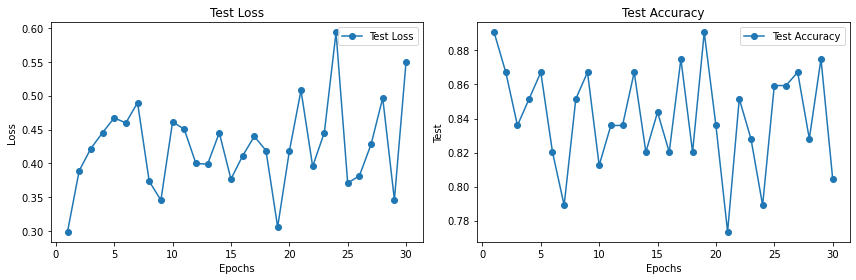

In [114]:
# Print or visualize the metrics
print(f'Average Loss: {loss_s:2f}')
print(f'Accuracy: {accuracy_s * 100:.2f}%')
# Plot the metrics
epochs_s = range(1, len(losses_s) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_s, losses_s, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_s,accuracies_s, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Test')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Average Loss: 0.4407
Accuracy: 84.85%


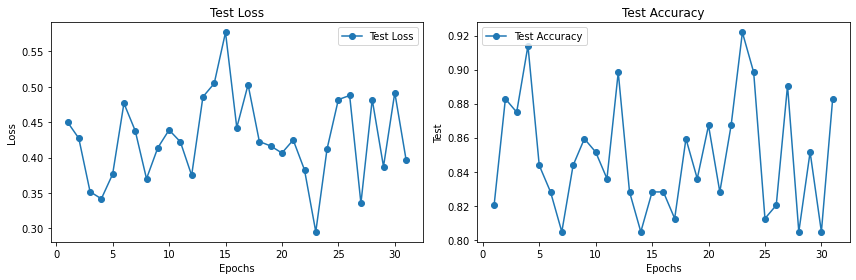

In [120]:
# Print or visualize the metrics
print(f'Average Loss: {loss_m:.4f}')
print(f'Accuracy: {accuracy_m * 100:.2f}%')
# Plot the metrics
epochs_m = range(1, len(losses_m) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_m, losses_m, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_m,accuracies_m, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Test')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

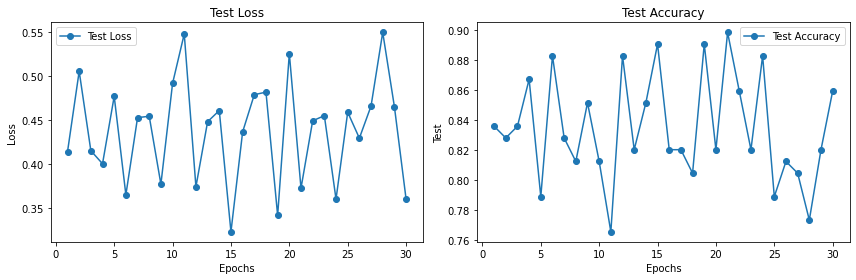

In [109]:
# Plot the metrics
epochs_v = range(1, len(losses_v) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_v, losses_v, label='Test Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_v,accuracies_v, label='Test Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Test')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

CONCLUSION

The small and medium verison have achieved more or less the same results, that are pretty good, but with more time nad maybe a more complex architecture structures they could be improved, while the vanilla model has a lower accuracy and higher loss so it performed wrost than the Sequencers2D Model, as it is in the paper results.

Small :
Average Loss: 0.424565
Accuracy: 84.11%

Medium:
Average Loss: 0.4407
Accuracy: 84.85%

Vanilla:
Average Loss: 0.9368
Accuracy: 67.77%


References

All the code is following the paper Sequencer: Deep LSTM for Image Classification 's explaination. It is refferred to the original code only for the parameteres number passed in the Sequencer2dBlocks and in the VanillaBlock (Parameters that are written in the paper too)

Pytorch libraries

matplot and numpy Lib.





